# Evaluation
This notebook will walk you step by step through the process of using the detection results files included in the zip folders of each pre-trained model.

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from itertools import cycle
from PIL import Image
import numpy as np
import pandas as pd
import pickle
import os
import copy

np.random.seed(1)

In [3]:
EPSILON = 1e-5
# Load GTSDB validation images
CLASSES = ['prohibitory','mandatory','danger']
#Path to the German Traffic Sign Detection Benchmark dataset
DATASET_PATH = '~/Datasets/GermanTSDataset/Detection'
full_set = ['%05d.jpg' % x for x in range(900)]
valid_set = full_set[600:900]

In [4]:
category_index = {1: {'id': 1, 'name': 'prohibitory'},
 2: {'id': 2, 'name': 'mandatory'},
 3: {'id': 3, 'name': 'danger'}}
categories = [{'id': 1, 'name': 'prohibitory'},
 {'id': 2, 'name': 'mandatory'},
 {'id': 3, 'name': 'danger'}]

## Load detection results

In [5]:
# MODEL_NAME = 'faster_rcnn_inception_resnet_v2_atrous'
MODEL_NAME = 'faster_rcnn_resnet_101'
# MODEL_NAME = 'faster_rcnn_resnet50'
# MODEL_NAME = 'faster_rcnn_inception_v2'
# MODEL_NAME = 'rfcn_resnet101'
# MODEL_NAME = 'ssd_inception_v2'
# MODEL_NAME = 'ssd_mobilenet_v1'
# MODEL_NAME = 'yolo_v2'

In [6]:
MODEL_PATH = os.path.join('models', MODEL_NAME)
with open(os.path.join(MODEL_PATH, 'detections_output_result.pkl'), 'rb') as pickle_file:
    detections = pickle.load(pickle_file)

## Helper code

In [7]:
def filter_val_detections(detections):
    fdetects = []
    for d in detections:
        if d['file'] in valid_set:
            fdetects.append(d)
    return fdetects

In [8]:
def filter_detections_by_width(detections, min_w, max_w):
    fdetects = []
    n_gt_bboxes = 0
    for d in detections:
        d_aux = copy.deepcopy(d)
        j = 0
        for i, bbox in enumerate(d['gt_bboxes']):
            w = bbox[2] - bbox[0]
            if w < min_w or w >= max_w:
                d_aux['gt_bboxes'].pop(i - j)
                d_aux['gt_classes'].pop(i - j)
                try:
                    d_aux['pred_bboxes'].pop(i - j)
                    d_aux['pred_classes'].pop(i - j)
                    d_aux['confidences'].pop(i - j)
                except IndexError:
                    print('Pred bbox num {} of image {} was not removed'.format(i,d_aux['file']))
                j += 1 
        n_gt_bboxes += len(d_aux['gt_bboxes'])
        fdetects.append(d_aux)
    print(n_gt_bboxes)
    return fdetects

In [9]:
def get_detection_by_filename(detections, filename):
    for detection in detections:
        if detection['file'] == filename:
            return detection

In [10]:
def plot_rectangle(bbox,ax,class_name,edgecolor,confidence=None):
    xmin = bbox[0]
    ymin = bbox[1]
    xmax = bbox[2]
    ymax = bbox[3]
    left = xmin
    right = xmax
    top = ymin
    bot = ymax
    ax.add_patch(
        plt.Rectangle((left, top),
                      right-left,
                      bot-top, fill=False,
                      edgecolor=edgecolor, linewidth=2)
        )
    label = '{:s}:'.format(class_name)
    label += ' {0:.2f}%'.format(confidence)
    label_pos_y = ((bot - top) / 2) + top + 3.5
    label_pos_x = right+10
    if class_name == 'danger':
        label_pos_x = left
        label_pos_y = top - 9
    elif class_name == 'prohibitory':
        label_pos_x = left - 30
        label_pos_y = bot + 15
    ax.text(label_pos_x, label_pos_y,label,
            bbox=dict(facecolor=edgecolor, edgecolor=edgecolor, alpha=1),
            fontsize=11)

In [11]:
CLASSES_COLOR = ['DarkOrange','Aqua','Chartreuse']
def plot_dets(detection, model_name):
    fig, ax = plt.subplots(figsize=(20, 20))
    image = np.array(Image.open(detection['file_path']))
    image = np.squeeze(image)
    imWidth = image.shape[1]
    imHeight = image.shape[0]
    for j in range(len(detection['pred_bboxes'])):
        pred_class = detection['pred_classes'][j]
        bbox = detection['pred_bboxes'][j]
        confidence = detection['confidences'][j] * 100
        plot_rectangle(bbox,ax,category_index[pred_class]['name'],CLASSES_COLOR[pred_class-1], confidence)
    plt.axis('off')
    ax.imshow(image, aspect='equal')

In [12]:
def intersection(bbgt, bb):
    # determine the (x, y)-coordinates of the intersection rectangle
    ixmin = max(bbgt[0], bb[0])
    iymin = max(bbgt[1], bb[1])
    ixmax = min(bbgt[2], bb[2])
    iymax = min(bbgt[3], bb[3])
    
    # compute the area of intersection rectangle
    iw = max(ixmax - ixmin, 0)
    ih = max(iymax - iymin, 0)
    intersArea = iw * ih
    
    return intersArea

In [13]:
def union(bbgt, bb, intersArea):
    # compute the area of both the prediction and ground-truth rectangles
    boxgtArea = (bbgt[2] - bbgt[0]) * (bbgt[3] - bbgt[1])
    boxArea = (bb[2] - bb[0]) * (bb[3] - bb[1])
    unionArea = boxgtArea + boxArea - intersArea
    return unionArea

In [14]:
# Returns the intersection over union of two rectangles, a and b, where each is an array [x,y,w,h]
def compute_iou(bbgt, bb):
    overlaps = np.zeros(len(bbgt))
    for i,gtBbox in enumerate(bbgt):
        inters = float(intersection(gtBbox, bb))
        uni = union(gtBbox, bb, inters)
        iou = inters/uni
        overlaps[i] = iou
    ioumax = np.max(overlaps)
    jmax = np.argmax(overlaps)
    return ioumax, jmax

In [15]:
def naive_ap_calculation(rec,prec):
    """
    Take sum of P(k) * \Delta recall(k)
    """
    deltaRecall = []
    rec = np.insert(rec,0,0)
    for i in range(1,rec.shape[0]):
        deltaRecall.append( rec[i] - rec[i-1] ) # find differences
    deltaRecall = np.array(deltaRecall)
    ap = np.dot( deltaRecall,prec)
    return ap

In [16]:
def voc_ap(rec, prec, use_07_metric=False):
    """ ap = voc_ap(rec, prec, [use_07_metric])
    Compute VOC AP given precision and recall.
    If use_07_metric is true, uses the
    VOC 07 11 point method (default:False).
    """
    if use_07_metric:
        # 11 point metric
        # http://host.robots.ox.ac.uk/pascal/VOC/pubs/everingham10.pdf (page 313)
        
        ap = 0.
        for t in np.arange(0., 1.1, 0.1):
            if np.sum(rec >= t) == 0:
                p = 0
            else:
                p = np.max(prec[rec >= t])
            ap = ap + p / 11.
    else:
        # correct AP calculation (from VOC 2010 challenge)
        # http://host.robots.ox.ac.uk/pascal/VOC/voc2012/devkit_doc.pdf (page 12)
        
        # first append sentinel values at the end
        mrec = np.concatenate(([0.], rec, [1.]))
        mpre = np.concatenate(([0.], prec, [0.]))

        # compute the precision envelope
        for i in range(mpre.size - 1, 0, -1):
            mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

        # to calculate area under PR curve, look for points
        # where X axis (recall) changes value
        i = np.where(mrec[1:] != mrec[:-1])[0]

        # and sum (\Delta recall) * prec
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

In [17]:
def match_gts_and_compute_prec_recall_ap(cls,detections,iouthresh=0.5):
    """
    INPUTS:
    -BB: predicted bounding boxes
    -BBGT: predicted bounding boxes, BBGT = R['bbox'].astype(float)
    OUTPUTS:
    -rec: recall
    -prec: precision
    -ap: average precision
    A bounding box reported by an algorithm is considered
    correct if its area intersection over union with a ground 
    truth bounding box is beyond 50%. If a lot of closely overlapping 
    bounding boxes hitting on a same ground truth, only one of
    them is counted as correct, and all the others are treated as false alarms
    """
    print('IoU threshold set to: {:.2f}'.format(iouthresh))
    GT_OBJECTS = {}
    BB = []
    BB_im_ids = []
    BB_confidences = []
    n_gt_bboxes = 0
    
    for dId,d in enumerate(detections):
        BBGT = []
        for i in range(len(d['gt_bboxes'])):
            if d['gt_classes'][i] == cls:
                BBGT.append(d['gt_bboxes'][i])
                n_gt_bboxes += 1
        GT_OBJECTS[d['file']] = {
            'bboxes' : np.asarray(BBGT),
            'detected?' : [False] * len(BBGT)
        }
        for i in range(len(d['pred_bboxes'])):
            if d['pred_classes'][i] == cls:
                BB.append(d['pred_bboxes'][i])
                BB_im_ids.append(d['file'])
                BB_confidences.append(d['confidences'][i])
      
    if n_gt_bboxes == 0:
        return None,None,None
    
    BB = np.asarray(BB)
    BB_confidences = np.asarray(BB_confidences)
    
    # sort by confidence
    if len(BB) > 0:
        sorted_ind = np.argsort(-BB_confidences)
        sorted_scores = np.sort(-BB_confidences)
        BB = BB[sorted_ind, :]
        BB_im_ids = [BB_im_ids[x] for x in sorted_ind]            
    
    num_detections = len(BB_im_ids)
    tp = np.zeros(num_detections)
    fp = np.zeros(num_detections)
    avg_overlap = []
    
    for d in range(num_detections):
        gt_info = GT_OBJECTS[BB_im_ids[d]]
        bb = BB[d, :].astype(float)
        BBGT = gt_info['bboxes'].astype(float)
        ioumax = -np.inf
        
        if BBGT.size > 0:
            # compute intersection over union
            ioumax, jmax = compute_iou(BBGT,bb)
        if ioumax > iouthresh:
            if not gt_info['detected?'][jmax]:
                tp[d] = 1. # true positive
                gt_info['detected?'][jmax] = 1
                avg_overlap.append(ioumax)
            else:
                fp[d] = 1. # false positive (multiple detection)
        else:
            fp[d] = 1. # false positive
        
    avg_overlap = np.array(avg_overlap) if len(avg_overlap) > 0 else np.array([0])
    
    # compute precision recall
    fp = np.cumsum(fp) if len(fp) > 0 else np.array([0])
    tp = np.cumsum(tp) if len(tp) > 0 else np.array([0])
    
    fn = n_gt_bboxes - tp[-1]
    
    rec = tp / np.maximum(tp + fn, np.finfo(np.float64).eps)
    # avoid divide by zero in case the first detection matches a difficult ground truth
    prec = tp / np.maximum(tp + fp, np.finfo(np.float64).eps)
    
    ap = voc_ap(rec, prec)
    
    print("TP: {}".format(tp[-1]))
    print("FP: {}".format(fp[-1]))
    print("FN: {}".format(fn))
    class_name = category_index[cls]['name']
    print('Avg. overlap for {} = {:.4f}'.format(class_name, np.mean(avg_overlap)))
    
    print('Precision for {} = {:.4f}'.format(class_name, prec[-1]))
    print('Recall for {} = {:.4f}'.format(class_name, rec[-1]))
    
    return rec, prec, ap

In [18]:
def plot_precision_recall(prec, recall, ap):
    # first append sentinel values at the end
    mrec = np.concatenate(([0.], recall, [recall[-1]]))
    mpre = np.concatenate(([prec[0]], prec, [0.]))
    # Plot Precision-Recall curve
    plt.clf()
    plt.plot(mrec, mpre, lw=2, color='navy',
             label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall: AP={0:0.2f}'.format(ap))
    plt.legend(loc="lower left")
    plt.show()

In [19]:
def plot_full_precision_recall(data):
    fig, ax = plt.subplots(figsize=(6, 4))
    lines = ["-","--","-.",":"]
    linecycler = cycle(lines)
    for d in data:
        recall = d['recall']
        prec = d['precision']
        ap = d['ap']
        cls = d['class']
        # first append sentinel values at the end
        mrec = np.concatenate(([0.], recall, [recall[-1]]))
        mpre = np.concatenate(([prec[0]], prec, [0.]))
        ax.plot(mrec, mpre, next(linecycler), label='{} (AP = {:.2f}%)'.format(cls,ap*100))
        
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.legend(loc="lower left")
    plt.draw()
    plt.tight_layout()
    plt.savefig('gtsdb_pre_rec_curves.pdf', format='pdf')
    plt.show()
    plt.clf()

In [20]:
def compute_mean_average_precision(detections):
    """
    INPUTS:
    -detections: python list of objects with fields: class_given_obj, confidences, bboxes
    OUTPUTS:
    -mAP: float
    For each class, we compute average precision (AP)
    This score corresponds to the area under the precision-recall curve.
    The mean of these numbers is the mAP.
    """
    
    results = []
    plot_data = []

#     plotDets(detections)
    aps = []
    
    for category in categories:
        class_name = category['name']
        rec, prec, ap = match_gts_and_compute_prec_recall_ap(category['id'],detections,iouthresh=0.5)
        
        if rec is None:
            continue
        results.append({'class' : class_name, 'precision' : prec[-1], 'recall' : rec[-1], 'ap' : ap})
        plot_data.append({'class' : class_name, 'precision' : prec, 'recall' : rec, 'ap' : ap})
        if ap is not None:
            aps += [ap]
            print('AP for {} = {:.4f}'.format(class_name, ap))
        plot_precision_recall(prec, rec, ap)
    print('Mean AP = {:.4f}'.format(np.mean(aps)))
    print('~~~~~~~~')
    print('Results:')
    mAP = np.mean(aps)
    df = pd.DataFrame.from_records(results, columns=('class', 'precision', 'recall', 'ap'))
    print(df)
    plot_full_precision_recall(plot_data)
    return mAP

In [21]:
def compute_mean_average_precision_COCO2016(detections):
    """
    INPUTS:
    -detections: python list of objects with fields: class_given_obj, confidences, bboxes
    OUTPUTS:
    -mAP: float
    For each class, we compute average precision (AP)
    This score corresponds to the area under the precision-recall curve.
    The mean of these numbers is the mAP.
    """

#     plotDets(detections)
    aps_class = []
    for category in categories:
        aps_iou = []
        for iouthresh in np.arange(.5, 1, .05):
            rec, prec, ap = match_gts_and_compute_prec_recall_ap(category['id'],detections,iouthresh)
            if ap is not None:
                aps_iou += [ap]
                print('AP for {} and IoU threshold {:.2f} = {:.4f}'.format(category['name'], iouthresh, ap))
            plot_precision_recall(prec, rec, ap)
        aps_class += [np.mean(aps_iou)] 
        print('Mean AP for {} = {:.4f}'.format(category['name'],np.mean(aps_iou)))
        
    print('Mean AP = {:.4f}'.format(np.mean(aps_class)))
    print('~~~~~~~~')
    print('Results:')
    for ap in aps_class:
        print('{:.3f}'.format(ap))
    print('{:.3f}'.format(np.mean(aps_class)))
    mAP = np.mean(aps_class)
    return mAP

## Filter detections

In [22]:
# Filter detections that belong to validation images
detections = filter_val_detections(detections)

In [23]:
# (0,32) (32,46) (46,1000)
detections_small = filter_detections_by_width(detections, 0, 32)
detections_medium = filter_detections_by_width(detections, 32, 46)
detections_large = filter_detections_by_width(detections, 46, 1000)

Pred bbox num 0 of image 00639.jpg was not removed
89
Pred bbox num 0 of image 00639.jpg was not removed
Pred bbox num 0 of image 00650.jpg was not removed
Pred bbox num 1 of image 00665.jpg was not removed
Pred bbox num 0 of image 00772.jpg was not removed
Pred bbox num 1 of image 00776.jpg was not removed
Pred bbox num 0 of image 00777.jpg was not removed
Pred bbox num 1 of image 00787.jpg was not removed
Pred bbox num 0 of image 00868.jpg was not removed
Pred bbox num 1 of image 00868.jpg was not removed
93
Pred bbox num 0 of image 00650.jpg was not removed
Pred bbox num 1 of image 00665.jpg was not removed
Pred bbox num 0 of image 00772.jpg was not removed
Pred bbox num 1 of image 00776.jpg was not removed
Pred bbox num 0 of image 00777.jpg was not removed
Pred bbox num 1 of image 00787.jpg was not removed
Pred bbox num 0 of image 00868.jpg was not removed
Pred bbox num 1 of image 00868.jpg was not removed
91


In [24]:
print(detections[0])

{'pred_classes': [1, 2, 2], 'pred_bboxes': [(822.4679946899414, 463.10906410217285, 846.4459848403931, 487.3554229736328), (385.26142835617065, 506.2324523925781, 432.69893407821655, 553.4314155578613), (544.0256643295288, 506.6349983215332, 569.1610217094421, 528.5330295562744)], 'gt_bboxes': [(387, 505, 434, 554), (821, 464, 845, 488)], 'file_path': '/media/arcos/Shared/Datasets/GermanTSDataset/Detection/00624.jpg', 'gt_classes': [2, 1], 'file': '00624.jpg', 'confidences': [0.9999832, 0.9999809, 0.974722]}


## Eval VOC Pascal 2010+

IoU threshold set to: 0.50
TP: 158.0
FP: 17.0
FN: 3.0
Avg. overlap for prohibitory = 0.8729
Precision for prohibitory = 0.9029
Recall for prohibitory = 0.9814
AP for prohibitory = 0.9813


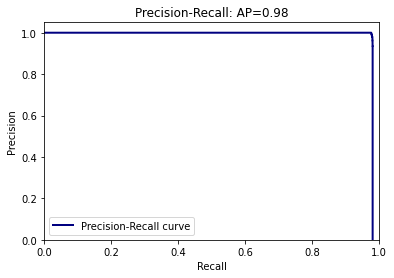

IoU threshold set to: 0.50
TP: 46.0
FP: 22.0
FN: 3.0
Avg. overlap for mandatory = 0.8558
Precision for mandatory = 0.6765
Recall for mandatory = 0.9388
AP for mandatory = 0.9346


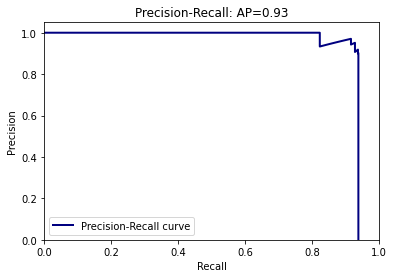

IoU threshold set to: 0.50
TP: 59.0
FP: 10.0
FN: 4.0
Avg. overlap for danger = 0.8705
Precision for danger = 0.8551
Recall for danger = 0.9365
AP for danger = 0.9364


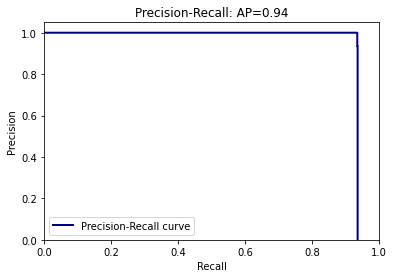

Mean AP = 0.9508
~~~~~~~~
Results:
         class  precision    recall        ap
0  prohibitory   0.902857  0.981366  0.981290
1    mandatory   0.676471  0.938776  0.934602
2       danger   0.855072  0.936508  0.936443


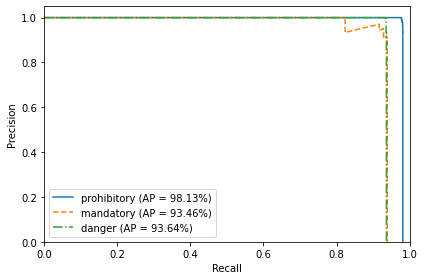

----- Small detections -----
IoU threshold set to: 0.50
TP: 51.0
FP: 18.0
FN: 6.0
Avg. overlap for prohibitory = 0.8340
Precision for prohibitory = 0.7391
Recall for prohibitory = 0.8947
AP for prohibitory = 0.8881


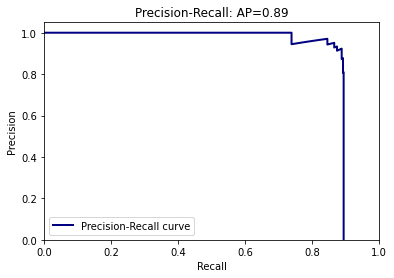

IoU threshold set to: 0.50
TP: 20.0
FP: 23.0
FN: 2.0
Avg. overlap for mandatory = 0.8203
Precision for mandatory = 0.4651
Recall for mandatory = 0.9091
AP for mandatory = 0.8441


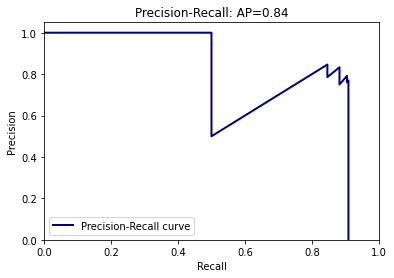

IoU threshold set to: 0.50
TP: 5.0
FP: 12.0
FN: 5.0
Avg. overlap for danger = 0.7328
Precision for danger = 0.2941
Recall for danger = 0.5000
AP for danger = 0.3945


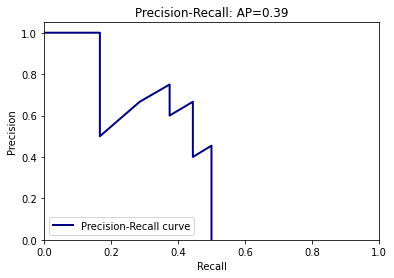

Mean AP = 0.7089
~~~~~~~~
Results:
         class  precision    recall        ap
0  prohibitory   0.739130  0.894737  0.888119
1    mandatory   0.465116  0.909091  0.844136
2       danger   0.294118  0.500000  0.394465


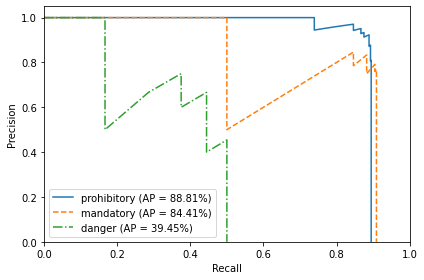

----- Medium detections -----
IoU threshold set to: 0.50
TP: 58.0
FP: 21.0
FN: 6.0
Avg. overlap for prohibitory = 0.8703
Precision for prohibitory = 0.7342
Recall for prohibitory = 0.9062
AP for prohibitory = 0.8957


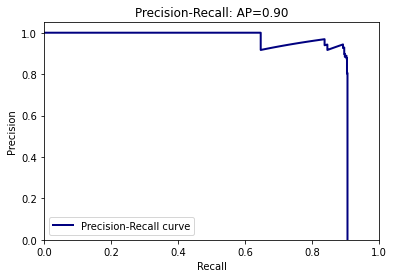

IoU threshold set to: 0.50
TP: 14.0
FP: 21.0
FN: 0.0
Avg. overlap for mandatory = 0.8580
Precision for mandatory = 0.4000
Recall for mandatory = 1.0000
AP for mandatory = 1.0000


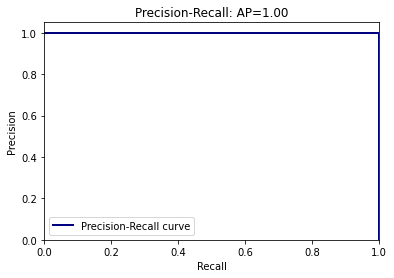

IoU threshold set to: 0.50
TP: 14.0
FP: 13.0
FN: 1.0
Avg. overlap for danger = 0.8490
Precision for danger = 0.5185
Recall for danger = 0.9333
AP for danger = 0.9295


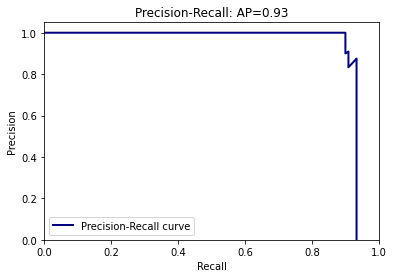

Mean AP = 0.9417
~~~~~~~~
Results:
         class  precision    recall        ap
0  prohibitory   0.734177  0.906250  0.895706
1    mandatory   0.400000  1.000000  1.000000
2       danger   0.518519  0.933333  0.929477


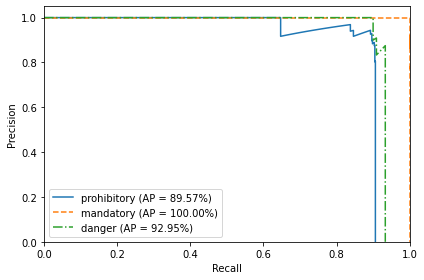

----- Large detections -----
IoU threshold set to: 0.50
TP: 37.0
FP: 24.0
FN: 3.0
Avg. overlap for prohibitory = 0.9167
Precision for prohibitory = 0.6066
Recall for prohibitory = 0.9250
AP for prohibitory = 0.9154


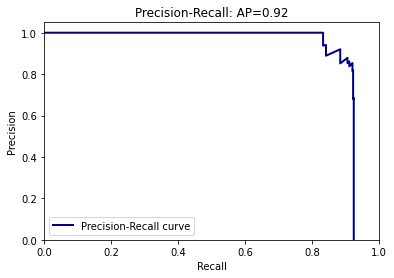

IoU threshold set to: 0.50
TP: 11.0
FP: 21.0
FN: 2.0
Avg. overlap for mandatory = 0.9133
Precision for mandatory = 0.3438
Recall for mandatory = 0.8462
AP for mandatory = 0.8298


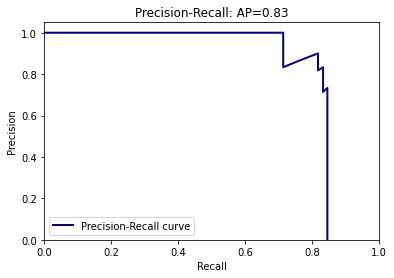

IoU threshold set to: 0.50
TP: 35.0
FP: 10.0
FN: 3.0
Avg. overlap for danger = 0.8993
Precision for danger = 0.7778
Recall for danger = 0.9211
AP for danger = 0.9211


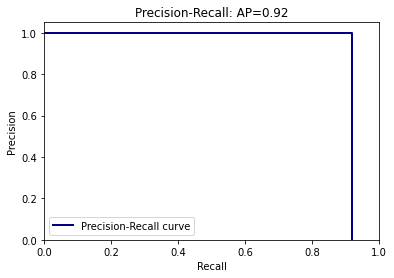

Mean AP = 0.8887
~~~~~~~~
Results:
         class  precision    recall        ap
0  prohibitory   0.606557  0.925000  0.915362
1    mandatory   0.343750  0.846154  0.829820
2       danger   0.777778  0.921053  0.921053


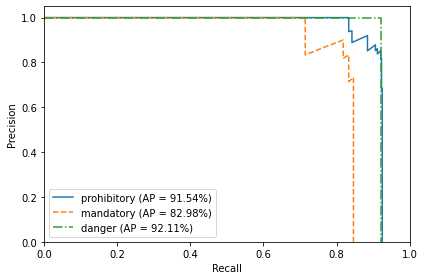

0.8887450073573325

<Figure size 432x288 with 0 Axes>

In [25]:
compute_mean_average_precision(detections)
print("----- Small detections -----")
compute_mean_average_precision(detections_small)
print("----- Medium detections -----")
compute_mean_average_precision(detections_medium)
print("----- Large detections -----")
compute_mean_average_precision(detections_large)

## Eval Microsoft COCO 2016

IoU threshold set to: 0.50
TP: 158.0
FP: 17.0
FN: 3.0
Avg. overlap for prohibitory = 0.8729
Precision for prohibitory = 0.9029
Recall for prohibitory = 0.9814
AP for prohibitory and IoU threshold 0.50 = 0.9813


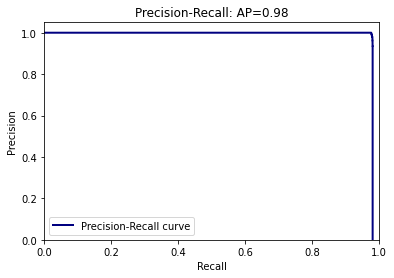

IoU threshold set to: 0.55
TP: 158.0
FP: 17.0
FN: 3.0
Avg. overlap for prohibitory = 0.8729
Precision for prohibitory = 0.9029
Recall for prohibitory = 0.9814
AP for prohibitory and IoU threshold 0.55 = 0.9813


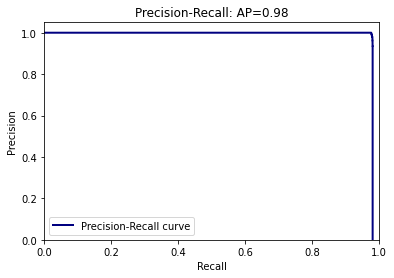

IoU threshold set to: 0.60
TP: 158.0
FP: 17.0
FN: 3.0
Avg. overlap for prohibitory = 0.8729
Precision for prohibitory = 0.9029
Recall for prohibitory = 0.9814
AP for prohibitory and IoU threshold 0.60 = 0.9813


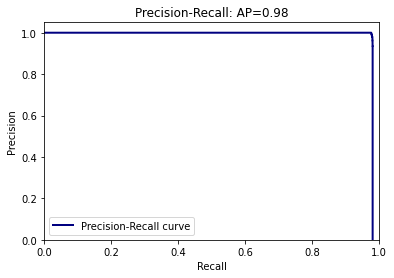

IoU threshold set to: 0.65
TP: 158.0
FP: 17.0
FN: 3.0
Avg. overlap for prohibitory = 0.8729
Precision for prohibitory = 0.9029
Recall for prohibitory = 0.9814
AP for prohibitory and IoU threshold 0.65 = 0.9813


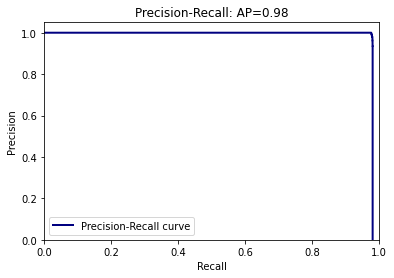

IoU threshold set to: 0.70
TP: 157.0
FP: 18.0
FN: 4.0
Avg. overlap for prohibitory = 0.8741
Precision for prohibitory = 0.8971
Recall for prohibitory = 0.9752
AP for prohibitory and IoU threshold 0.70 = 0.9749


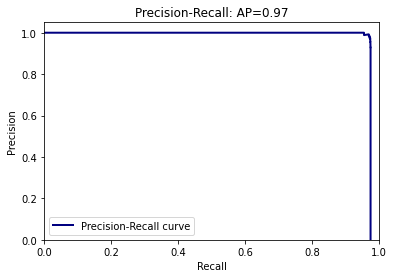

IoU threshold set to: 0.75
TP: 153.0
FP: 22.0
FN: 8.0
Avg. overlap for prohibitory = 0.8779
Precision for prohibitory = 0.8743
Recall for prohibitory = 0.9503
AP for prohibitory and IoU threshold 0.75 = 0.9483


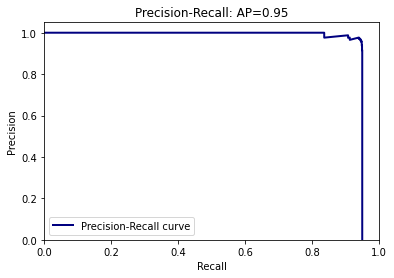

IoU threshold set to: 0.80
TP: 135.0
FP: 40.0
FN: 26.0
Avg. overlap for prohibitory = 0.8907
Precision for prohibitory = 0.7714
Recall for prohibitory = 0.8385
AP for prohibitory and IoU threshold 0.80 = 0.7999


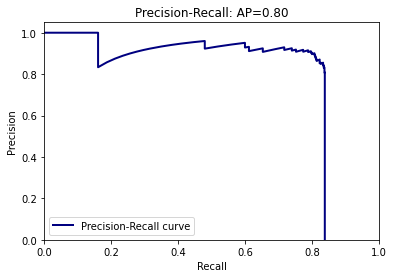

IoU threshold set to: 0.85
TP: 102.0
FP: 73.0
FN: 59.0
Avg. overlap for prohibitory = 0.9108
Precision for prohibitory = 0.5829
Recall for prohibitory = 0.6335
AP for prohibitory and IoU threshold 0.85 = 0.5453


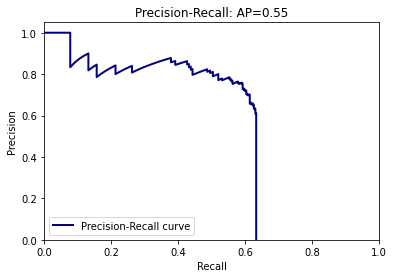

IoU threshold set to: 0.90
TP: 60.0
FP: 115.0
FN: 101.0
Avg. overlap for prohibitory = 0.9336
Precision for prohibitory = 0.3429
Recall for prohibitory = 0.3727
AP for prohibitory and IoU threshold 0.90 = 0.2325


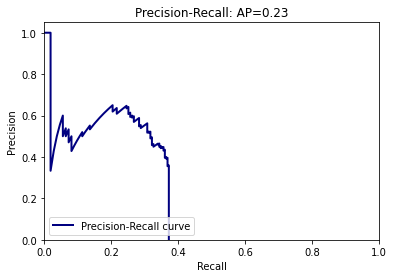

IoU threshold set to: 0.95
TP: 15.0
FP: 160.0
FN: 146.0
Avg. overlap for prohibitory = 0.9620
Precision for prohibitory = 0.0857
Recall for prohibitory = 0.0932
AP for prohibitory and IoU threshold 0.95 = 0.0152


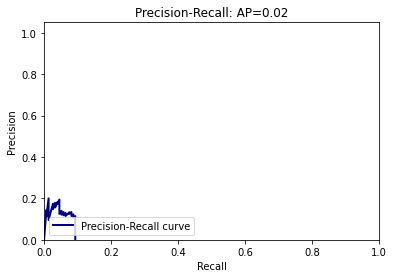

Mean AP for prohibitory = 0.7441
IoU threshold set to: 0.50
TP: 46.0
FP: 22.0
FN: 3.0
Avg. overlap for mandatory = 0.8558
Precision for mandatory = 0.6765
Recall for mandatory = 0.9388
AP for mandatory and IoU threshold 0.50 = 0.9346


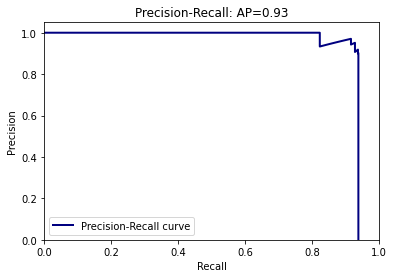

IoU threshold set to: 0.55
TP: 46.0
FP: 22.0
FN: 3.0
Avg. overlap for mandatory = 0.8558
Precision for mandatory = 0.6765
Recall for mandatory = 0.9388
AP for mandatory and IoU threshold 0.55 = 0.9346


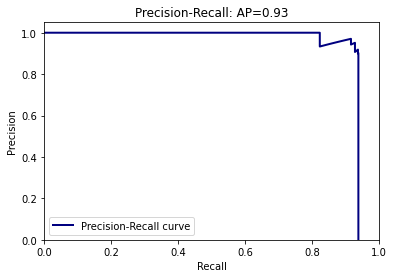

IoU threshold set to: 0.60
TP: 46.0
FP: 22.0
FN: 3.0
Avg. overlap for mandatory = 0.8558
Precision for mandatory = 0.6765
Recall for mandatory = 0.9388
AP for mandatory and IoU threshold 0.60 = 0.9346


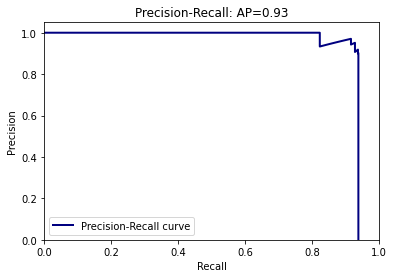

IoU threshold set to: 0.65
TP: 46.0
FP: 22.0
FN: 3.0
Avg. overlap for mandatory = 0.8558
Precision for mandatory = 0.6765
Recall for mandatory = 0.9388
AP for mandatory and IoU threshold 0.65 = 0.9346


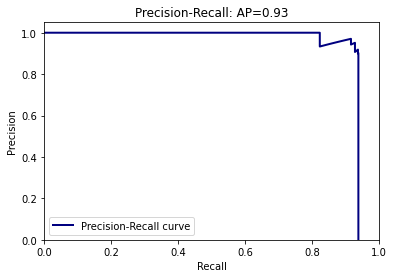

IoU threshold set to: 0.70
TP: 45.0
FP: 23.0
FN: 4.0
Avg. overlap for mandatory = 0.8600
Precision for mandatory = 0.6618
Recall for mandatory = 0.9184
AP for mandatory and IoU threshold 0.70 = 0.9133


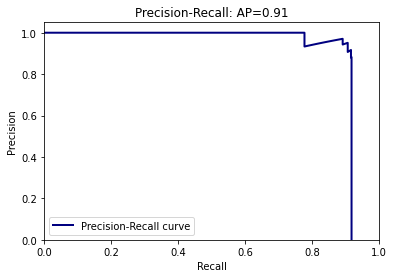

IoU threshold set to: 0.75
TP: 42.0
FP: 26.0
FN: 7.0
Avg. overlap for mandatory = 0.8692
Precision for mandatory = 0.6176
Recall for mandatory = 0.8571
AP for mandatory and IoU threshold 0.75 = 0.8448


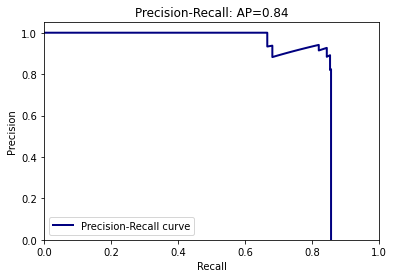

IoU threshold set to: 0.80
TP: 35.0
FP: 33.0
FN: 14.0
Avg. overlap for mandatory = 0.8865
Precision for mandatory = 0.5147
Recall for mandatory = 0.7143
AP for mandatory and IoU threshold 0.80 = 0.6457


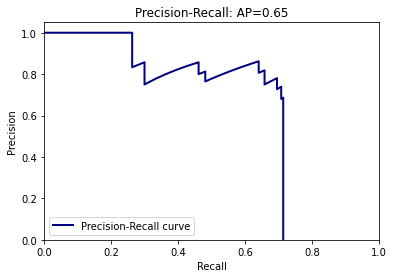

IoU threshold set to: 0.85
TP: 27.0
FP: 41.0
FN: 22.0
Avg. overlap for mandatory = 0.9059
Precision for mandatory = 0.3971
Recall for mandatory = 0.5510
AP for mandatory and IoU threshold 0.85 = 0.4105


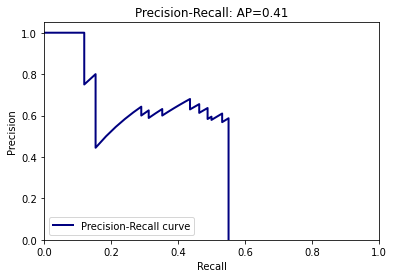

IoU threshold set to: 0.90
TP: 16.0
FP: 52.0
FN: 33.0
Avg. overlap for mandatory = 0.9286
Precision for mandatory = 0.2353
Recall for mandatory = 0.3265
AP for mandatory and IoU threshold 0.90 = 0.1897


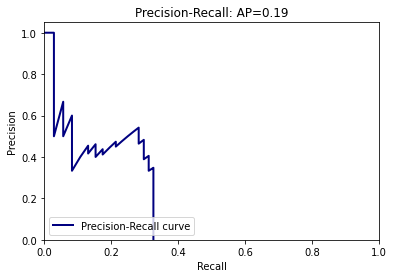

IoU threshold set to: 0.95
TP: 1.0
FP: 67.0
FN: 48.0
Avg. overlap for mandatory = 0.9623
Precision for mandatory = 0.0147
Recall for mandatory = 0.0204
AP for mandatory and IoU threshold 0.95 = 0.0009


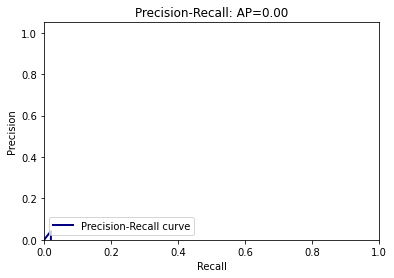

Mean AP for mandatory = 0.6743
IoU threshold set to: 0.50
TP: 59.0
FP: 10.0
FN: 4.0
Avg. overlap for danger = 0.8705
Precision for danger = 0.8551
Recall for danger = 0.9365
AP for danger and IoU threshold 0.50 = 0.9364


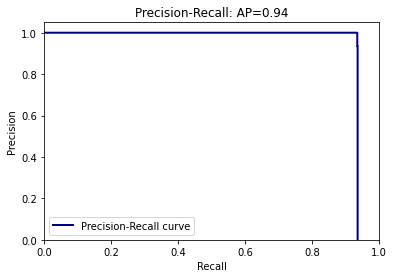

IoU threshold set to: 0.55
TP: 59.0
FP: 10.0
FN: 4.0
Avg. overlap for danger = 0.8705
Precision for danger = 0.8551
Recall for danger = 0.9365
AP for danger and IoU threshold 0.55 = 0.9364


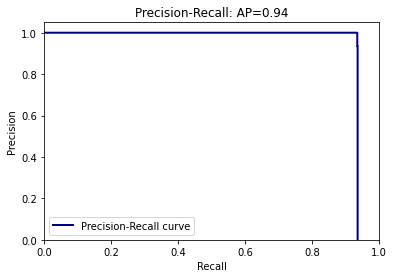

IoU threshold set to: 0.60
TP: 59.0
FP: 10.0
FN: 4.0
Avg. overlap for danger = 0.8705
Precision for danger = 0.8551
Recall for danger = 0.9365
AP for danger and IoU threshold 0.60 = 0.9364


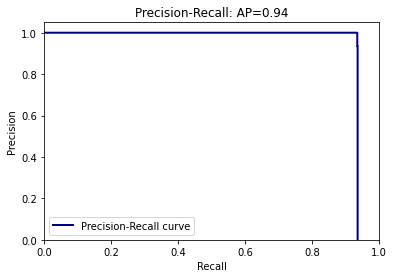

IoU threshold set to: 0.65
TP: 57.0
FP: 12.0
FN: 6.0
Avg. overlap for danger = 0.8791
Precision for danger = 0.8261
Recall for danger = 0.9048
AP for danger and IoU threshold 0.65 = 0.9046


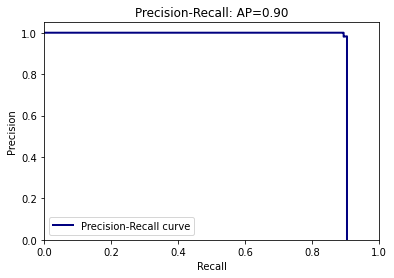

IoU threshold set to: 0.70
TP: 57.0
FP: 12.0
FN: 6.0
Avg. overlap for danger = 0.8791
Precision for danger = 0.8261
Recall for danger = 0.9048
AP for danger and IoU threshold 0.70 = 0.9046


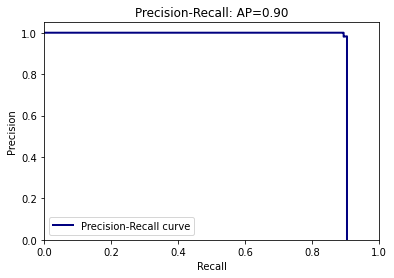

IoU threshold set to: 0.75
TP: 55.0
FP: 14.0
FN: 8.0
Avg. overlap for danger = 0.8843
Precision for danger = 0.7971
Recall for danger = 0.8730
AP for danger and IoU threshold 0.75 = 0.8567


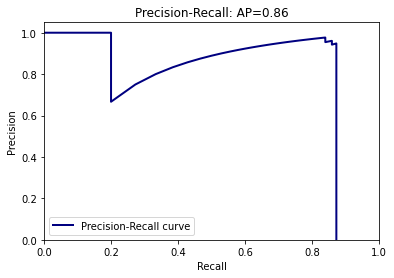

IoU threshold set to: 0.80
TP: 54.0
FP: 15.0
FN: 9.0
Avg. overlap for danger = 0.8866
Precision for danger = 0.7826
Recall for danger = 0.8571
AP for danger and IoU threshold 0.80 = 0.8167


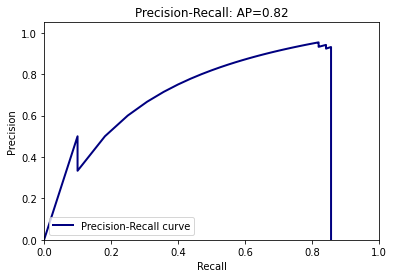

IoU threshold set to: 0.85
TP: 42.0
FP: 27.0
FN: 21.0
Avg. overlap for danger = 0.9024
Precision for danger = 0.6087
Recall for danger = 0.6667
AP for danger and IoU threshold 0.85 = 0.5036


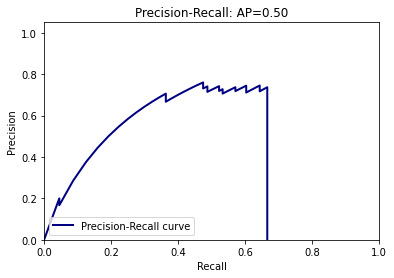

IoU threshold set to: 0.90
TP: 21.0
FP: 48.0
FN: 42.0
Avg. overlap for danger = 0.9320
Precision for danger = 0.3043
Recall for danger = 0.3333
AP for danger and IoU threshold 0.90 = 0.1279


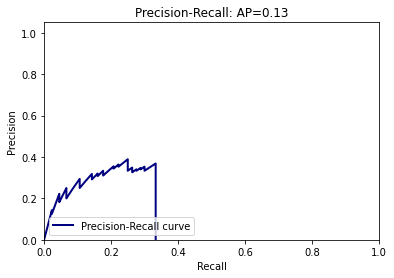

IoU threshold set to: 0.95
TP: 4.0
FP: 65.0
FN: 59.0
Avg. overlap for danger = 0.9613
Precision for danger = 0.0580
Recall for danger = 0.0635
AP for danger and IoU threshold 0.95 = 0.0045


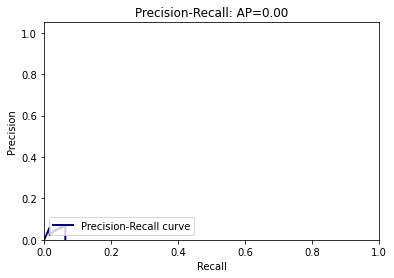

Mean AP for danger = 0.6928
Mean AP = 0.7037
~~~~~~~~
Results:
0.744
0.674
0.693
0.704


0.7037434966397799

In [26]:
compute_mean_average_precision_COCO2016(detections)

## Plot detections

In [27]:
sample = get_detection_by_filename(detections, '00780.jpg')
sample

{'pred_classes': [1, 1, 3, 3],
 'pred_bboxes': [(1164.8351764678955,
   576.0062217712402,
   1228.6061716079712,
   638.208532333374),
  (381.427059173584, 558.796501159668, 442.7958130836487, 620.805549621582),
  (1144.984474182129, 489.7498607635498, 1234.087119102478, 581.239128112793),
  (364.94680643081665,
   468.3372974395752,
   466.27413511276245,
   559.9035263061523)],
 'gt_bboxes': [(365, 468, 466, 558),
  (1165, 572, 1227, 636),
  (1142, 487, 1237, 575),
  (380, 557, 444, 621)],
 'file_path': '/media/arcos/Shared/Datasets/GermanTSDataset/Detection/00780.jpg',
 'gt_classes': [3, 1, 3, 1],
 'file': '00780.jpg',
 'confidences': [0.9999914, 0.9999815, 0.9999745, 0.99995434]}

FileNotFoundError: [Errno 2] No such file or directory: '/media/arcos/Shared/Datasets/GermanTSDataset/Detection/00780.jpg'

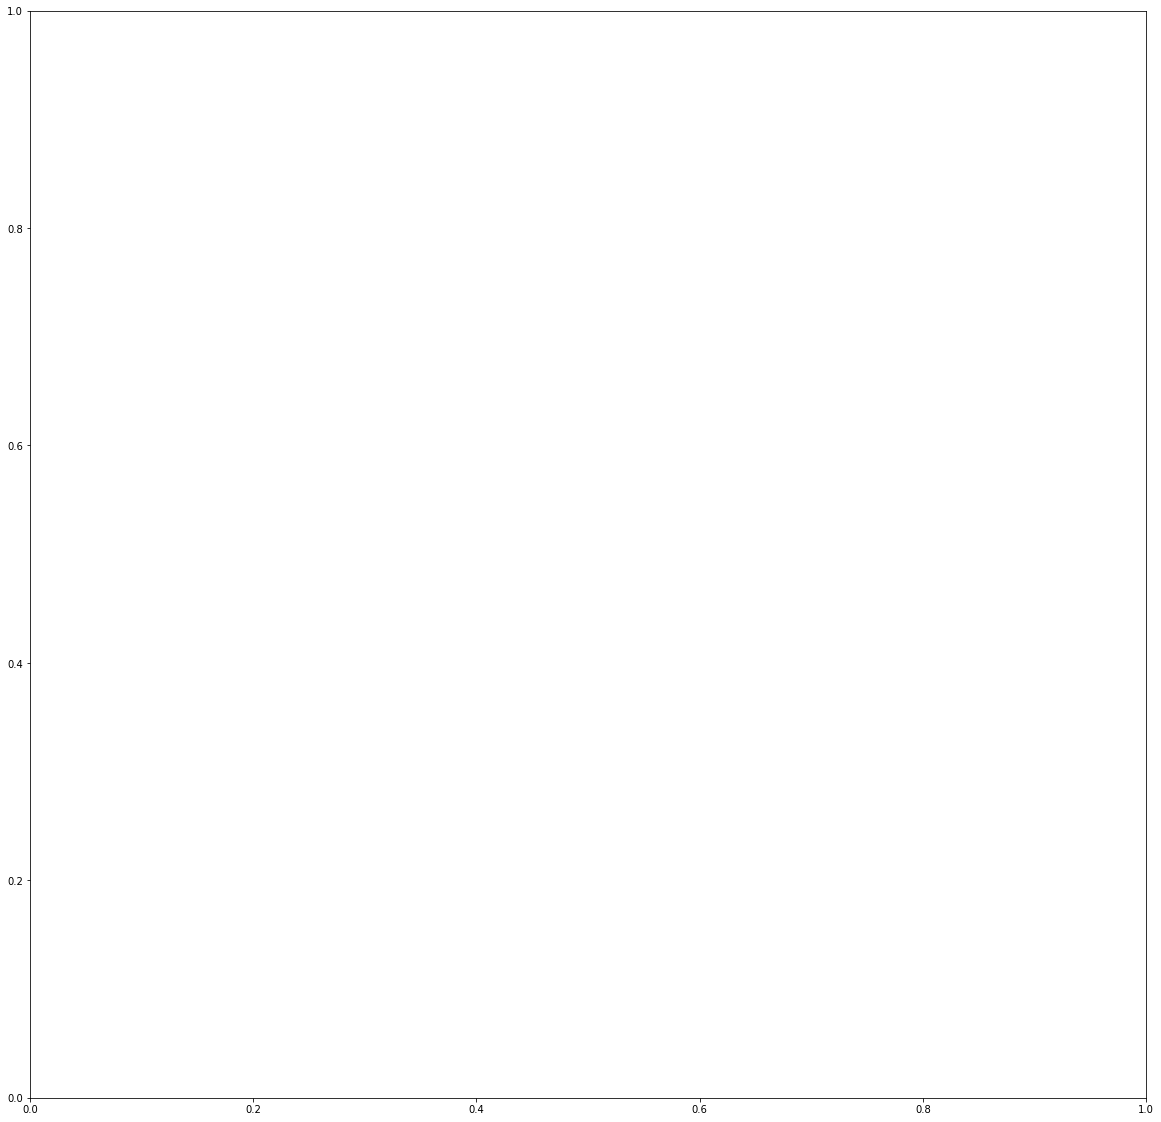

In [28]:
plot_dets(sample, MODEL_NAME)